In this notebook, we will evaluate the effect of three different loss functions in a semantic segmentation task:
*   cross entropy (traditionally used loss function for segmentation)
*   "combo loss", a mixed loss function of cross entropy and dice loss (see Taghanaki et al. [Combo Loss: Handling Input and Output Imbalance in Multi-Organ Segmentation](https://arxiv.org/pdf/1805.02798.pdf). **2018**)
*   active contour loss (Chen et al. [Learning Active Contour Models for Medical Image Segmentation](https://core.ac.uk/download/pdf/326246499.pdf). **2019**).

The dataset we will be tackling here is the ZJU-RGB-P dataset of outdoor scenes. This dataset of Kaiwei Wang et al. can be found here: http://wangkaiwei.org/file/RGB-P-dataset.rar

It is a multiclass semantic segmentation task. There are 9 classes, 344 training and 50 validation images. It is polarimetric image dataset. To keep it simple here, we will however ignore this fact and only use 0° images and just ignore the other polarization angles.

I have already uploaded the dataset to my Google Drive which I will connect to this notebook in the next step:

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install pytorch_lightning
!pip install torchinfo
!pip install torchmetrics==0.7.0
!pip install pyunpack
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.6/396.6 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.0.0
    Uninstalling torchmetrics-1.0.0:
      Successfully uninstalled torchmetrics-1.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 4.0 MB/s eta 0:00:00


In [3]:
import glob
from pathlib import Path
import albumentations as A
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass, field
from typing import List
from torch.nn import (
    Conv2d, ReLU, Softmax, BatchNorm2d, MaxPool2d, Upsample)
from torchinfo import summary
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.patches as mpatches
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import JaccardIndex
import pandas as pd
import logging
import pyunpack
from functools import partial
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

random.seed(2)
torch.manual_seed(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Let's define some hyperparameters:

In [4]:
resized_dims = (448, 528)

contractions = 4
filters_in = 3 # RGB images
filters_init = 32

batch_size = 8

# General training parameters
epochs = 130
patience_early_stopping = 80

lr_after_warmup = 5e-4
lr_decay = 0.98
lr_max = lr_after_warmup * 4
lr_min = 5e-8
warmup_epochs = 5
f_reduction = 0.25
f_restart = 1.7
patience = 3
min_loss_improvement = 0.001
no_of_restarts_init = 2
increment_no_of_restarts = 1

Let's unpack the dataset archive and get the file paths of the images:

In [5]:
archive = pyunpack.Archive("./drive/MyDrive/RGB-P-dataset.rar")
archive.extractall(directory= "./")

fps_imgs_train = [x for x in glob.glob("./train/0/*.png")]
fps_imgs_val = [x for x in glob.glob("./val/0/*.png")]
fps_masks_train = [x for x in glob.glob("./train/label/*.png")]
fps_masks_val = [x for x in glob.glob("./val/label/*.png")]

fps_imgs_train.sort()
fps_imgs_val.sort()
fps_masks_train.sort()
fps_masks_val.sort()

classes = {0: "background",
           1: "building",
           2: "glass",
           3: "car",
           4: "road",
           5: "tree",
           6: "sky",
           7: "pedestrian",
           8: "bicycle"}

no_classes = len(classes)
print(f"There are {no_classes} classes in this data set")

There are 9 classes in this data set


Now we will create our Pytorch dataset and dataloader. Importantly, we will resize images to 448x528 px to ease the computational burden in this notebook.

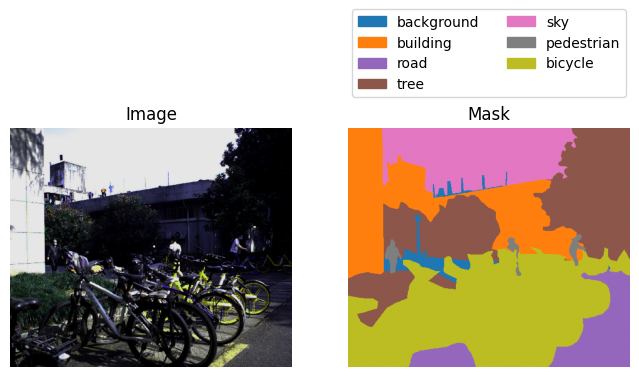

In [6]:
class CustomDataset(Dataset):
    def __init__(self, fps_imgs, fps_masks, resized_dims, no_classes, augment):
        self.fps_imgs = fps_imgs
        self.fps_masks = fps_masks
        self.resized_dims = resized_dims
        self.no_classes = no_classes
        self.augment = augment

    def __len__(self):
        return len(self.fps_imgs)

    def __getitem__(self, idx):
        fp_img = self.fps_imgs[idx]
        fp_mask = self.fps_masks[idx]

        img = np.array(Image.open(fp_img))
        mask = np.expand_dims(np.array(Image.open(fp_mask)), 2)

        # Augment
        transform_augment = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(p=0.3),
            A.RandomResizedCrop(
                self.resized_dims[0], self.resized_dims[1], scale=(0.3, 0.9),
                interpolation=cv2.INTER_NEAREST, p=0.3),
            ])
        if self.augment:
            transformed = transform_augment(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]

        # Resize
        transform = A.Compose([
            A.Resize(self.resized_dims[0], self.resized_dims[1],
                     interpolation=cv2.INTER_NEAREST),
            ])
        transformed = transform(image=img, mask=mask)
        img = transformed["image"]
        mask = torch.tensor(transformed["mask"])

        mask = F.one_hot(mask[:, :, 0].long(), num_classes=self.no_classes)

        img = torch.tensor(np.moveaxis(img, 2, 0) / 255).float()
        mask = torch.moveaxis(mask, 2, 0).float()
        return img, mask


ds_train = CustomDataset(
    fps_imgs_train, fps_masks_train, resized_dims, no_classes, augment=True)
ds_val = CustomDataset(
    fps_imgs_val, fps_masks_val, resized_dims, no_classes, augment=False)

idx0 = 13
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
img0, mask0 = ds_train[idx0]
mask0 = np.argmax(mask0.numpy(), axis=0)


def mask_to_rgb(mask, classes):
    mask_out = np.zeros(mask.shape + (3,))
    cur_class_vals = np.unique(mask)
    cur_class_names = [classes[x] for x in cur_class_vals]
    cmap = mpl.colormaps["tab10"]
    cur_rgbs = []

    for idx1, val in enumerate(cur_class_vals):
        idx2 = np.where(mask == val)
        rgb = cmap(val / len(classes))[0:3]
        mask_out[idx2[0], idx2[1], :] = rgb
        cur_rgbs.append(rgb)
    return mask_out, cur_class_names, cur_rgbs

mask0_rgb, cur_class_names, cur_rgbs = mask_to_rgb(mask0, classes)
patches0 = [mpatches.Patch(color=cur_rgbs[idx], label=class_name)
            for idx, class_name in enumerate(cur_class_names)]

ax[0].imshow(np.moveaxis(img0.numpy(), 0, 2))
ax[0].set_title("Image")
ax[1].imshow(mask0_rgb)
ax[1].set_title("Mask")
ax[1].legend(handles=patches0, loc="lower center",
             bbox_to_anchor=(0, 1.1, 1, 0.2), ncol=2)
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

loader_train = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, num_workers=2,
    pin_memory=True)
loader_val = DataLoader(
    ds_val, batch_size=batch_size, shuffle=False, num_workers=2,
    pin_memory=True)

For semantic segmentation, we will use a U-net model. Here we will first define the "node connections" of our U-net taking an approach previously explained in this notebook:

https://github.com/cstckr/semantic_segmentation_with_UNet_UNet2plus_UNet3plus_and_UNetsharp/blob/main/semantic_segmentation_with_UNet_UNet2plus_UNet3plus_and_UNetsharp.ipynb

In [7]:
@dataclass
class Node:
    i: int = None
    j: int = None
    con_in: List[int] = field(default_factory=list)
    con_type: List[int] = field(default_factory=list)
    f_in: int = None
    f_out: int = None


def find_idx_from_i_j(nodes, i, j):
    return [(x.i, x.j) for x in nodes].index((i, j))


def find_connections_unet(nodes, cur_i, cur_j):
    con_in = []
    con_type = []
    f_in = 0
    f_out = []

    for node in nodes:
        if (((node.i - cur_i == 1) & (node.i + node.j == cur_i + cur_j)) or
         (node.i == cur_i)):
            idx = find_idx_from_i_j(nodes, node.i, node.j)
            con_in.append(idx)
            con_type.append(node.i - cur_i)
            f_in += nodes[idx].f_out
            f_out.append(nodes[idx].f_out)
    return con_in, con_type, f_in, min(f_out)


def create_nodes_unet(contractions, filters_in, filters_init):
    nodes = []

    # Contraction
    nodes.append(Node(0, 0, [], [], filters_in, filters_init))
    for i in range(1, contractions+1):
        nodes.append(Node(
            i, 0, [i-1], [-1], filters_init * 2**(i-1), filters_init * 2**i))

    # Everything else
    for j in range(1, contractions+1):
        i = contractions - j
        con_in, con_type, f_in, f_out = find_connections_unet(
            nodes, i, j)
        nodes.append(Node(i, j, con_in, con_type, f_in, f_out))

    return nodes


nodes1 = create_nodes_unet(contractions, filters_in, filters_init)
_ = [print(x) for x in nodes1]

Node(i=0, j=0, con_in=[], con_type=[], f_in=3, f_out=32)
Node(i=1, j=0, con_in=[0], con_type=[-1], f_in=32, f_out=64)
Node(i=2, j=0, con_in=[1], con_type=[-1], f_in=64, f_out=128)
Node(i=3, j=0, con_in=[2], con_type=[-1], f_in=128, f_out=256)
Node(i=4, j=0, con_in=[3], con_type=[-1], f_in=256, f_out=512)
Node(i=3, j=1, con_in=[3, 4], con_type=[0, 1], f_in=768, f_out=256)
Node(i=2, j=2, con_in=[2, 5], con_type=[0, 1], f_in=384, f_out=128)
Node(i=1, j=3, con_in=[1, 6], con_type=[0, 1], f_in=192, f_out=64)
Node(i=0, j=4, con_in=[0, 7], con_type=[0, 1], f_in=96, f_out=32)


Now, we will actually create this U-net model defined by the node list created above:

In [8]:
class UNetBlock(nn.Module):
    def __init__(self, filters_in, filters_out):
        super().__init__()
        self.conv1 = Conv2d(
            in_channels=filters_in, out_channels=filters_out,
            kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(
            in_channels=filters_out, out_channels=filters_out,
            kernel_size=3, stride=1, padding=1)
        self.activation = ReLU()
        self.bn1 = BatchNorm2d(filters_out)
        self.bn2 = BatchNorm2d(filters_out)

    def forward(self, x):
        x = torch.cat(x, dim=1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
        return x


class Connector(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, times=1):
        if times==0:
            return x
        if times>0:
            return Upsample(scale_factor=2 ** times, mode="bilinear")(x)
        if times<0:
            return MaxPool2d((2 ** abs(times), 2 ** abs(times)))(x)


class UNet(nn.Module):
    def __init__(self, nodes, no_classes):
        super().__init__()
        self.nodes = nodes
        self.no_classes = no_classes
        self.layers = nn.ModuleList()
        self.build_layers()

    def build_layers(self):
        for node in self.nodes:
            self.layers.append(
                UNetBlock(filters_in=node.f_in, filters_out=node.f_out)
                )
        self.connector = Connector()
        self.final = Conv2d(
            in_channels=self.nodes[-1].f_out, out_channels=self.no_classes,
            kernel_size=3, stride=1, padding=1)
        self.softmax = Softmax(dim=1)

    def forward(self, x):
        out = []
        for idx, layer in enumerate(self.layers):
            if idx==0:
                out.append(self.layers[idx]([x]))
            else:
                layer_input = [self.connector(out[x], y) for (x, y) in
                               zip(self.nodes[idx].con_in,
                                   self.nodes[idx].con_type)]
                out.append(self.layers[idx](layer_input))

        x = self.final(out[-1])
        x = self.softmax(x)
        return x


unet = UNet(nodes1, no_classes)
summary(unet, (1, filters_in,) + resized_dims, depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 9, 448, 528]          --
├─ModuleList: 1-21                       --                        (recursive)
│    └─UNetBlock: 2-1                    [1, 32, 448, 528]         10,272
├─Connector: 1-2                         [1, 32, 224, 264]         --
├─ModuleList: 1-21                       --                        (recursive)
│    └─UNetBlock: 2-2                    [1, 64, 224, 264]         55,680
├─Connector: 1-4                         [1, 64, 112, 132]         --
├─ModuleList: 1-21                       --                        (recursive)
│    └─UNetBlock: 2-3                    [1, 128, 112, 132]        221,952
├─Connector: 1-6                         [1, 128, 56, 66]          --
├─ModuleList: 1-21                       --                        (recursive)
│    └─UNetBlock: 2-4                    [1, 256, 56, 66]          886,272
├─Connector: 1-8               

We will use a custom learning rate scheduler that is not really relevant to this notebook:

In [9]:
class MultiplicativeDecayWithReduceOrRestartOnPlateau:
    def __init__(self, optimizer, lr_after_warmup, lr_decay, lr_max, lr_min,
                 warmup_epochs, f_reduction, f_restart, patience,
                 min_loss_improvement, no_of_restarts_init,
                 increment_no_of_restarts):
        self.optimizer = optimizer
        self.lr_after_warmup = lr_after_warmup
        self.lr_decay = lr_decay
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.warmup_epochs = warmup_epochs
        self.f_reduction = f_reduction
        self.f_restart = f_restart
        self.patience = patience
        self.min_loss_improvement = min_loss_improvement
        self.no_of_restarts_init = no_of_restarts_init
        self.increment_no_of_restarts = increment_no_of_restarts

        self.loss_best = np.Inf
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.just_restarted = False
        self.set_par("initial_lr", self.lr_min)
        self.set_par("lr", self.lr_min)
        self.epoch = 0

    def get_par(self, name):
        for group in self.optimizer.param_groups: par = group[name]
        return par

    def set_par(self, name, value):
        for group in self.optimizer.param_groups: group[name] = value

    def on_loss_improvement(self, loss_cur):
        self.loss_best = loss_cur
        self.plateau_epochs = 0

    def on_loss_deterioration(self):
        self.plateau_epochs += 1

    def multiplicative_decay_lr(self, lr):
        return lr * self.lr_decay

    def on_plateau(self, lr):
        if self.reductions_counter >= self.no_of_restarts_init:
            lr_new = self.restart_lr()
        else:
            lr_new = self.steep_reduce_lr(lr)
        return lr_new

    def steep_reduce_lr(self, lr):
        lr_new = lr * self.f_reduction
        self.plateau_epochs = 0
        self.reductions_counter += 1
        return lr_new

    def restart_lr(self):
        self.lr_after_warmup *= self.f_restart
        lr_new = self.lr_after_warmup
        if lr_new > self.lr_max:
            lr_new = self.lr_max
        self.plateau_epochs = 0
        self.reductions_counter = 0
        self.no_of_restarts_init += self.increment_no_of_restarts
        self.just_restarted = True
        return lr_new

    def warmup(self):
        lr_new = self.lr_min + (self.lr_after_warmup - self.lr_min) * (
            self.epoch / self.warmup_epochs)
        return lr_new

    def step(self, metrics):
        if self.epoch <= self.warmup_epochs:
            lr_new = self.warmup()
        else:
            lr_cur = self.get_par("lr")
            loss_cur = float(metrics)

            if 1 - (loss_cur / self.loss_best) > self.min_loss_improvement:
                self.on_loss_improvement(loss_cur)
            else:
                self.on_loss_deterioration()
            lr_new = self.multiplicative_decay_lr(lr_cur)

            if self.just_restarted:
                self.loss_best = loss_cur
                self.just_restarted = False

            if self.plateau_epochs >= self.patience:
                lr_new = self.on_plateau(lr_cur)

            if lr_new <= self.lr_min:
                lr_new = self.restart_lr()

        self.set_par("lr", lr_new)
        self.epoch += 1

# Cross entropy
Now we will train our U-net model using cross entropy as a loss function:

In [10]:
cb_a1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b1 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c1 = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(save_dir="logs/", name="model001_unet",
                    flush_logs_every_n_steps=1)


class UNetModule(pl.LightningModule):
    def __init__(self, net, no_classes, loss_func):
        super().__init__()
        self.automatic_optimization = False
        self.unet = net
        self.test_iou = JaccardIndex(num_classes=no_classes)
        self.loss_func = loss_func

    def forward(self, x):
        x = self.unet(x)
        return x

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt.zero_grad()
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = self.loss_func(y_pred, y)

        # For logging loss & metrics
        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        self.manual_backward(loss)
        opt.step()
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        loss = self.loss_func(y_pred, y)

        # For logging loss & metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

        if batch_idx == 0:
            self.cur_val_loss = []
        self.cur_val_loss.append(loss)
        return loss

    def on_validation_epoch_end(self):
        # Take care of non-default scheduler
        self.cur_val_loss = torch.stack(self.cur_val_loss).mean()
        self.scheduler.step(self.cur_val_loss)

    def test_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_pred = self.forward(x)
        self.test_iou.update(
            torch.argmax(y_pred, dim=1).to(torch.uint8),
            torch.argmax(y, dim=1).to(torch.uint8))

    def on_test_epoch_end(self):
        result = self.test_iou.compute()
        print(f"Mean Intersection-over-union on test data: {result*100:.1f}%")
        self.test_iou.reset()
        return result

    def predict_step(self, batch, batch_idx):
        if isinstance(batch, list): # Dataloaders that return both X and y
            return torch.argmax(
                self(batch[0]), dim=1), torch.argmax(batch[1], dim=1)
        else: # Dataloaders that return only y
            return torch.argmax(self(batch[0]), dim=1)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=lr_min)
        self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
            optimizer=opt, lr_after_warmup=lr_after_warmup, lr_decay=lr_decay,
            lr_max=lr_max, lr_min=lr_min, warmup_epochs=warmup_epochs,
            f_reduction=f_reduction, f_restart=f_restart, patience=patience,
            min_loss_improvement=min_loss_improvement,
            no_of_restarts_init=no_of_restarts_init,
            increment_no_of_restarts=increment_no_of_restarts)
        return opt


ce_loss_func = partial(F.cross_entropy, reduction="mean")
model001 = UNetModule(unet, no_classes, ce_loss_func)

trainer1a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1,
    callbacks=[cb_a1, cb_b1, cb_c1], logger=logger1, accelerator="gpu",
    devices=1, enable_progress_bar=False)

trainer1a.fit(
    model=model001, train_dataloaders=loader_train, val_dataloaders=loader_val)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Visualization of the training progress:

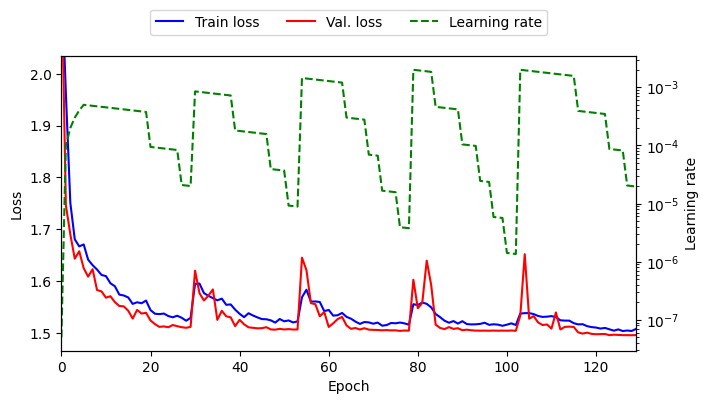

In [11]:
logs1 = pd.read_csv(Path(trainer1a.logger.log_dir + "/metrics.csv"))


def plot_training_progress(logs, ylim_factor=0.75):
    epochs = logs.dropna(subset=["train_loss"])["epoch"]

    fig1, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    l1 = ax1.plot(
        epochs, logs["train_loss"].dropna(), color="b", label="Train loss")
    l2 = ax1.plot(
        epochs, logs["val_loss"].dropna(), color="r", label="Val. loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_xlim(0, len(epochs)-1)

    loss_min1 = logs["train_loss"].min()
    loss_min2 = logs["val_loss"].min()
    loss_max1 = logs["train_loss"].max()
    loss_max2 = logs["val_loss"].max()

    ax1.set_ylim(
        min(loss_min1, loss_min2) * 0.98,
        ((max(loss_max1, loss_max2) - min(loss_min1, loss_min2)) * ylim_factor
         + min(loss_min1, loss_min2)))
    ax2 = ax1.twinx()
    l3 = ax2.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed",
        label="Learning rate")
    ax2.set_ylabel("Learning rate")
    ax2.set_yscale("log")
    ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc="lower center",
              bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)

    plt.tight_layout(pad=4)
    plt.show()


plot_training_progress(logs1)

And evaluation of intersection-over-union on the validation dataset:

In [12]:
checkpoint_file = trainer1a.checkpoint_callback.best_model_path
model001 = model001.load_from_checkpoint(
    checkpoint_file, net=unet, no_classes=no_classes, loss_func=ce_loss_func)
model001.eval()

trainer1b = pl.Trainer(accelerator="gpu", devices=1, enable_progress_bar=False)
_ = trainer1b.test(model=model001, dataloaders=loader_val)

Mean Intersection-over-union on test data: 46.9%


Let's look at an exemplary prediction:

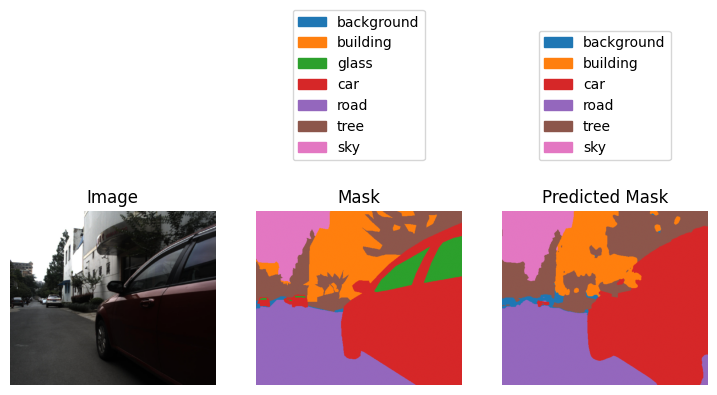

In [13]:
idx1 = 33
img1, mask1 = ds_val[idx1]

mask1 = np.argmax(mask1.numpy(), axis=0)
mask1_rgb, cur_class_names, cur_rgbs = mask_to_rgb(mask1, classes)
patches1 = [mpatches.Patch(color=cur_rgbs[idx], label=class_name)
            for idx, class_name in enumerate(cur_class_names)]

mask1a_pred = model001(ds_val[idx1][0][None, :, :, :])


mask1a_pred = torch.argmax(mask1a_pred[0, :, :, :], dim=0).numpy()


mask1a_pred_rgb, cur_class_names_pred, cur_rgbs_pred = mask_to_rgb(
    mask1a_pred, classes)
patches1a_pred = [mpatches.Patch(color=cur_rgbs_pred[idx], label=class_name)
                 for idx, class_name in enumerate(cur_class_names_pred)]

fig, ax = plt.subplots(1, 3, figsize=(9, 8))
ax[0].imshow(np.moveaxis(img1.numpy(), 0, 2))
ax[0].set_title("Image")
ax[1].imshow(mask1_rgb)
ax[1].set_title("Mask")
ax[1].legend(handles=patches1, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)
ax[2].imshow(mask1a_pred_rgb)
ax[2].set_title("Predicted Mask")
ax[2].legend(handles=patches1a_pred, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)

[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

# Combination of cross entropy and dice loss
Now we will train the same U-net model using the "combo loss" that is a mixed loss of cross entropy and dice loss:

In [14]:
def dice_loss(y_true, y_pred, num_classes):
    intersection = torch.sum(y_pred * y_true, (0, 2, 3))
    cardinality = torch.sum(y_pred + y_true, (0, 2, 3))
    dice_loss = (2. * intersection / (cardinality + torch.finfo(
        torch.float32).eps)).mean()
    return (1 - dice_loss)


def combo_loss(y_true, y_pred, num_classes, weight=1):
    ce_term = F.cross_entropy(y_pred, y_true, reduction="mean")
    dice_term = dice_loss(y_true, y_pred, num_classes)
    return ce_term + weight * dice_term


cb_a2 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b2 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c2 = LearningRateMonitor(logging_interval="epoch")
logger2 = CSVLogger(save_dir="logs/", name="model002_unet",
                    flush_logs_every_n_steps=1)

unet002 = UNet(nodes1, no_classes)
combo_loss_func = partial(combo_loss, num_classes=no_classes, weight=1)
model002 = UNetModule(unet, no_classes, combo_loss_func)

trainer2a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1,
    callbacks=[cb_a2, cb_b2, cb_c2], logger=logger2, accelerator="gpu",
    devices=1, enable_progress_bar=False)

trainer2a.fit(
    model=model002, train_dataloaders=loader_train, val_dataloaders=loader_val)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


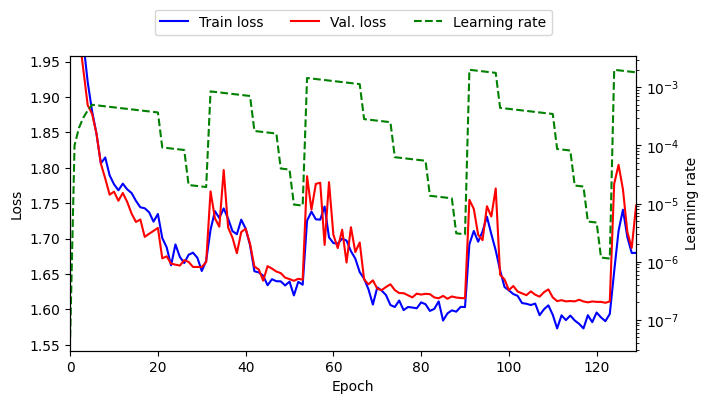

In [15]:
logs2 = pd.read_csv(Path(trainer2a.logger.log_dir + "/metrics.csv"))
plot_training_progress(logs2, 0.9)

Evaluating the mean intersection-over-union, we can already see quite an impressive improvement compared to only using cross entropy as a loss function:

In [16]:
checkpoint_file = trainer2a.checkpoint_callback.best_model_path
model002 = model002.load_from_checkpoint(checkpoint_file, net=unet002, no_classes=no_classes, loss_func=combo_loss_func)
model002.eval()

trainer2b = pl.Trainer(accelerator="gpu", devices=1, enable_progress_bar=False)
_ = trainer2b.test(model=model002, dataloaders=loader_val)

Mean Intersection-over-union on test data: 76.7%


We will look again at an examplary prediction:

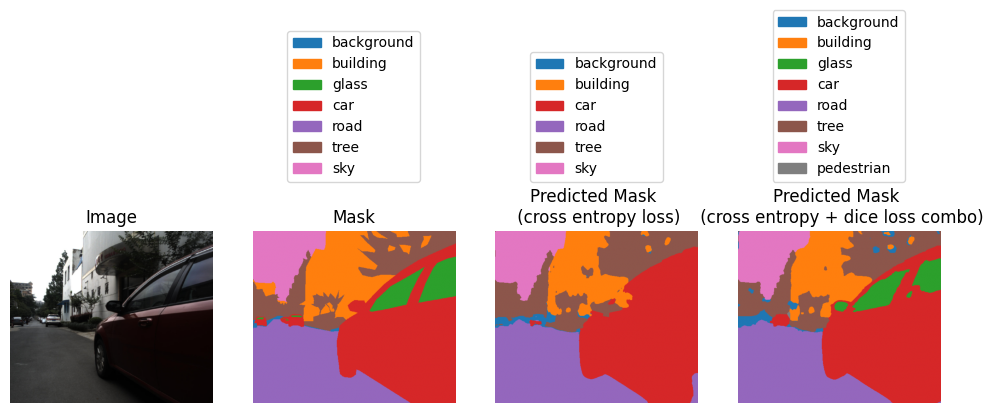

In [17]:
mask1b_pred = model002(ds_val[idx1][0][None, :, :, :])
mask1b_pred = torch.argmax(mask1b_pred[0, :, :, :], dim=0).numpy()

mask1b_pred_rgb, cur_class_names_pred, cur_rgbs_pred = mask_to_rgb(mask1b_pred, classes)
patches1b_pred = [mpatches.Patch(color=cur_rgbs_pred[idx], label=class_name)
                 for idx, class_name in enumerate(cur_class_names_pred)]

fig, ax = plt.subplots(1, 4, figsize=(12, 8))
ax[0].imshow(np.moveaxis(img1.numpy(), 0, 2))
ax[0].set_title("Image")
ax[1].imshow(mask1_rgb)
ax[1].set_title("Mask")
ax[1].legend(handles=patches1, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)
ax[2].imshow(mask1a_pred_rgb)
ax[2].set_title("Predicted Mask \n (cross entropy loss)")
ax[2].legend(handles=patches1a_pred, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)

ax[3].imshow(mask1b_pred_rgb)
ax[3].set_title("Predicted Mask \n (cross entropy + dice loss combo)")
ax[3].legend(handles=patches1b_pred, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)

[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

# Active contour loss
Finally, we will train the same U-net model using the active contour loss function. The loss function is adapted from the original Keras implementation that can be found here:

https://github.com/xuuuuuuchen/Active-Contour-Loss/blob/master/Active-Contour-Loss.py

In [18]:
def active_contour_loss(y_true, y_pred, weight=10):
    x = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:]
    y = y_pred[:,:,:,1:] - y_pred[:,:,:,:-1]

    delta_x = x[:,:,1:,:-2]**2
    delta_y = y[:,:,:-2,1:]**2
    delta_u = torch.abs(delta_x + delta_y)

    length = torch.mean(torch.sqrt(delta_u + torch.finfo(torch.float32).eps))
    C_1  = torch.ones_like(y_pred)
    C_2 = torch.zeros_like(y_pred)

    region_in = torch.mean(y_pred * (y_true - C_1)**2)
    region_out = torch.mean((1 - y_pred) * (y_true - C_2)**2)
    region = region_in + region_out

    loss =  weight * length + (region_out + region_in)
    return loss


cb_a3 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b3 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb_c3 = LearningRateMonitor(logging_interval="epoch")
logger3 = CSVLogger(save_dir="logs/", name="model003_unet",
                    flush_logs_every_n_steps=1)

unet003 = UNet(nodes1, no_classes)
ac_loss_func = partial(active_contour_loss, weight=10)
model003 = UNetModule(unet, no_classes, ac_loss_func)

trainer3a = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1,
    callbacks=[cb_a3, cb_b3, cb_c3], logger=logger3, accelerator="gpu",
    devices=1, enable_progress_bar=False)

trainer3a.fit(
    model=model003, train_dataloaders=loader_train, val_dataloaders=loader_val)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


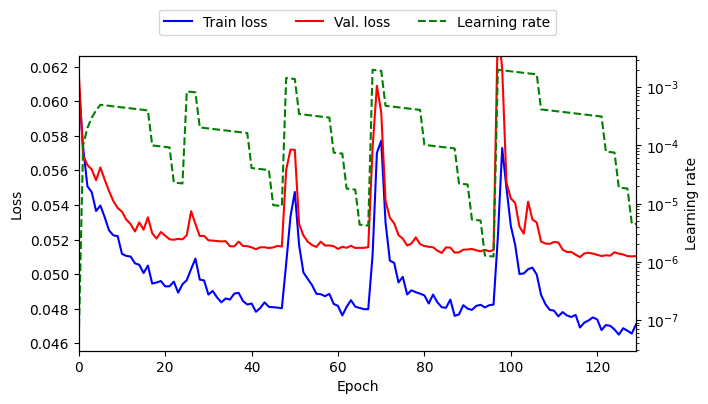

In [19]:
logs3 = pd.read_csv(Path(trainer3a.logger.log_dir + "/metrics.csv"))
plot_training_progress(logs3, 0.9)

Evaluating the mean intersection-over-union on the validation dataset, we can see a slight additional improvement compared to using the "combo loss":

In [20]:
checkpoint_file = trainer3a.checkpoint_callback.best_model_path
model003 = model003.load_from_checkpoint(
    checkpoint_file, net=unet003, no_classes=no_classes, loss_func=ac_loss_func)
model003.eval()

trainer3b = pl.Trainer(accelerator="gpu", devices=1, enable_progress_bar=False)
_ = trainer3b.test(model=model003, dataloaders=loader_val)

Mean Intersection-over-union on test data: 79.0%


And last, we will again look at an exemplary prediction:

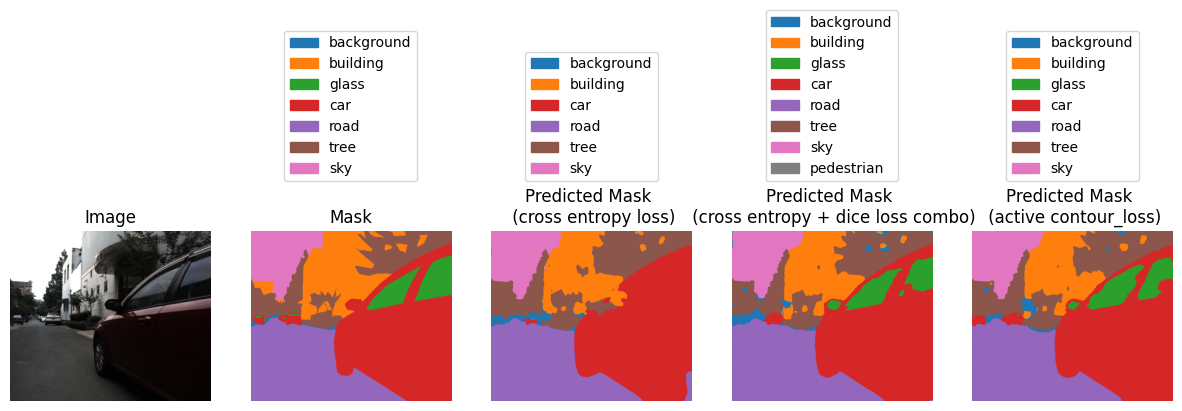

In [21]:
mask1c_pred = model003(ds_val[idx1][0][None, :, :, :])
mask1c_pred = torch.argmax(mask1c_pred[0, :, :, :], dim=0).numpy()

mask1c_pred_rgb, cur_class_names_pred, cur_rgbs_pred = mask_to_rgb(
    mask1c_pred, classes)
patches1c_pred = [mpatches.Patch(color=cur_rgbs_pred[idx], label=class_name)
                 for idx, class_name in enumerate(cur_class_names_pred)]

fig, ax = plt.subplots(1, 5, figsize=(15, 8))
ax[0].imshow(np.moveaxis(img1.numpy(), 0, 2))
ax[0].set_title("Image")
ax[1].imshow(mask1_rgb)
ax[1].set_title("Mask")
ax[1].legend(handles=patches1, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)
ax[2].imshow(mask1a_pred_rgb)
ax[2].set_title("Predicted Mask \n (cross entropy loss)")
ax[2].legend(handles=patches1a_pred, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)
ax[3].imshow(mask1b_pred_rgb)
ax[3].set_title("Predicted Mask \n (cross entropy + dice loss combo)")
ax[3].legend(handles=patches1b_pred, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)
ax[4].imshow(mask1c_pred_rgb)
ax[4].set_title("Predicted Mask \n (active contour_loss)")
ax[4].legend(handles=patches1c_pred, loc="lower center",
             bbox_to_anchor=(0, 1.25, 1, 0.2), ncol=1)
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

In summary, we have seen that the two loss functions "combo loss" and active contour loss can yield a quite impressive improvement over using traditional cross entropy loss. I definitely do not expect an effect size as large as in this notebook for every other dataset. But any time you are in desperate need to improve your semantic segmentation model, using one of the loss functions showcased in this notebook might be worth a try.